<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [1]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [2]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26118 sha256=4a619654e2c64e08e95da2c2b4cca2524757ac941537724425fd80465a750e50
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
  Created wheel for stringdist: filename=StringDist-1.0.9-cp39-cp39-linux_x86_64.whl size=24704 sha256=af8aba5e35fe678256ddbd63e743abb1f526f7980fa5e4d454db9c120823cad9
  Stored in directory: /root/.cache/pip/wheels/77/24/44/b12b9612fd07e141e6b4f1bb2001c621515bd0cac1014a783a
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s e

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [5]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [6]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
230665,147635,Entered ICU,2124-11-22 21:55:59
230666,167802,Entered ICU,2200-02-26 18:40:12
230667,186391,Entered ICU,2134-01-08 21:59:39
230668,156213,Entered ICU,2107-02-05 17:16:52


## Section 2: Process Discovery

In [7]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-7-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [8]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [9]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 29340
Number of events: 160233
Start events: {'Admitted': 29340}
End events: {'Discharged': 29340}


In [10]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

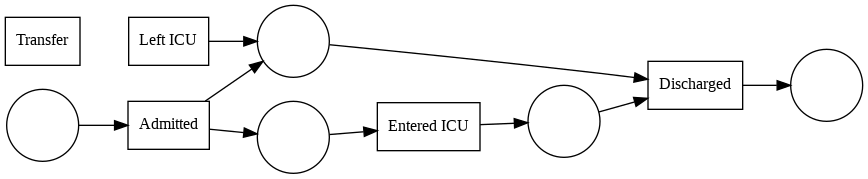

In [11]:
import graphviz
pm.view_petri_net(petri_net=net)

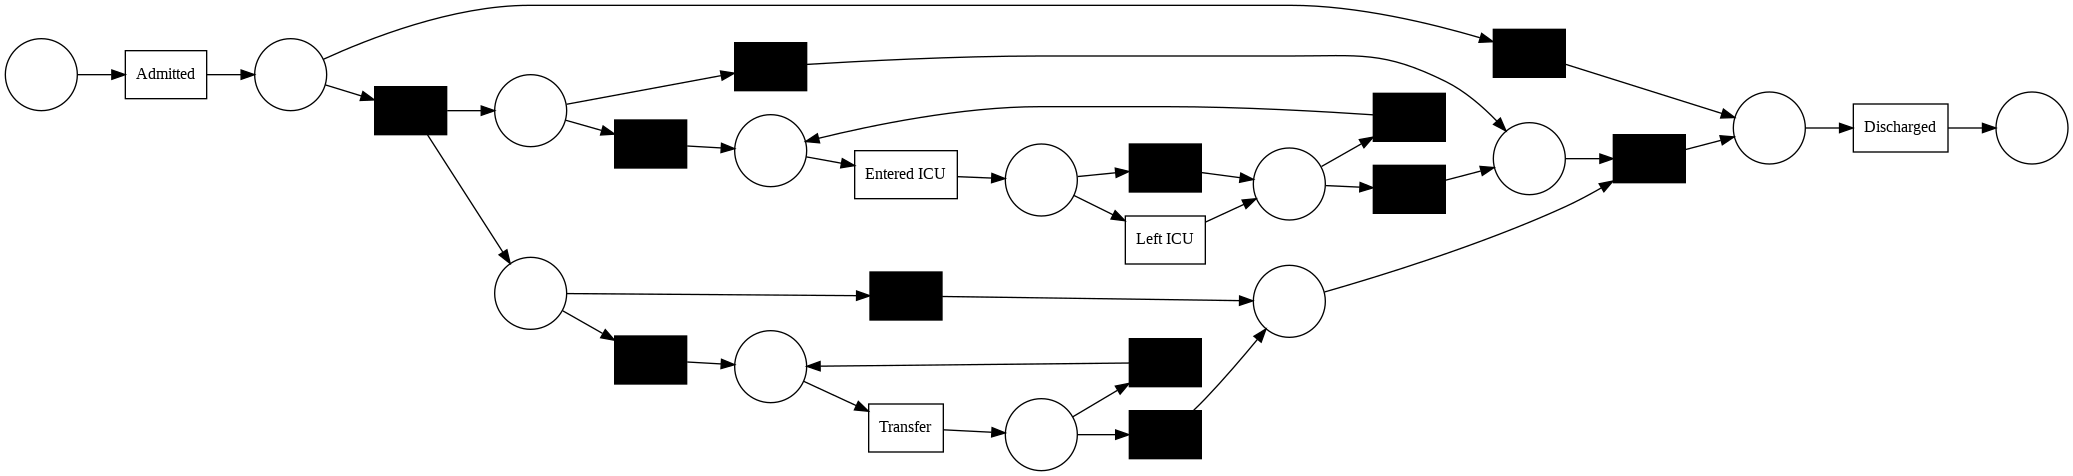

In [12]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

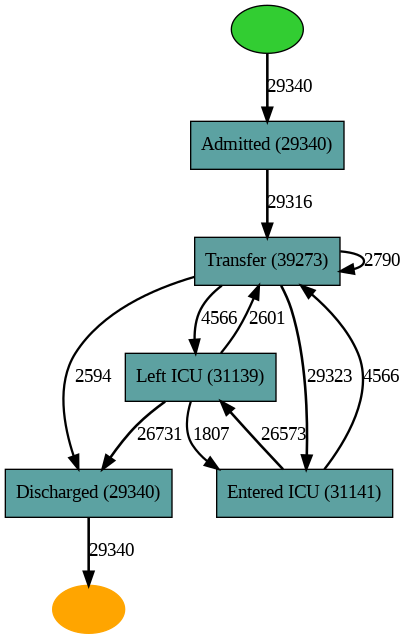

In [13]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

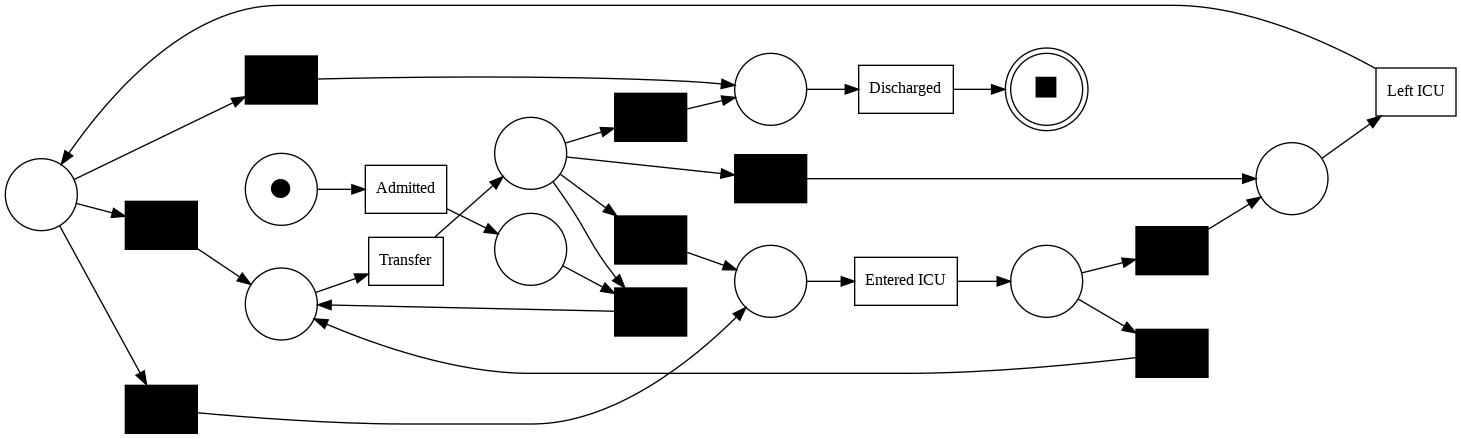

In [14]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

#Section 3: Preprocessing Data

In [15]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [16]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
513,92,Admitted,2168-12-05 00:22:00
514,92,Transfer,2168-12-05 00:22:53
515,92,Entered ICU,2168-12-05 00:22:53
516,92,Left ICU,2168-12-08 21:08:34
517,92,Transfer,2168-12-09 16:00:55
...,...,...,...
160045,29306,Admitted,2173-11-19 16:14:00
160046,29306,Transfer,2173-11-19 16:15:02
160047,29306,Entered ICU,2173-11-19 21:15:41
160048,29306,Left ICU,2173-11-26 23:10:08


In [17]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
6989,1267,Admitted,2153-02-19 04:33:00
6990,1267,Transfer,2153-02-19 04:34:12
6991,1267,Entered ICU,2153-02-19 04:34:12
6992,1267,Left ICU,2153-02-20 22:57:53
6993,1267,Discharged,2153-02-22 13:11:00
...,...,...,...
143872,26349,Entered ICU,2120-12-27 16:20:01
143873,26349,Left ICU,2121-01-06 00:42:51
143874,26349,Entered ICU,2121-01-08 20:35:30
143875,26349,Left ICU,2121-01-24 17:05:52


In [18]:
import numpy as np
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [19]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
6989,1267,Admitted,2153-02-19 04:33:00
6990,1267,Transfer,2153-02-19 04:34:12
6991,1267,Entered ICU,2153-02-19 04:34:12
6992,1267,Left ICU,2153-02-20 22:57:53
6993,1267,Discharged,NaT
...,...,...,...
143872,26349,Entered ICU,2120-12-27 16:20:01
143873,26349,Left ICU,2121-01-06 00:42:51
143874,26349,Entered ICU,2121-01-08 20:35:30
143875,26349,Left ICU,2121-01-24 17:05:52


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

###4.2

In [28]:
def generate_traces(sequence, missing):
    # timestamps = 
    print(missing)
    if missing.iat[0,1] == 'Admitted':
      print('Admitted')
      return
    if missing.iat[0,1] == 'Discharged':
      print('Discharged')
      return

    # for t in len 

    pass


In [29]:
def predict_sequences(el):
  df = pd.DataFrame(columns=['prefix', 'suffix', 'prefix deltas', 'suffix deltas', 'label'])
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]

    
    predicted_trace = generate_traces(sequence, missing)
    


    # for i in trace_df['index']:



  return df

predict_sequences(test_x)


     trace    activity timestamp
6993  1267  Discharged       NaT
Discharged
      trace  activity timestamp
10122  1845  Transfer       NaT
      trace    activity timestamp
24203  4429  Discharged       NaT
Discharged
      trace    activity timestamp
25908  4746  Discharged       NaT
Discharged
      trace  activity timestamp
30489  5586  Transfer       NaT
      trace  activity timestamp
32620  5979  Transfer       NaT
      trace  activity timestamp
32726  5999  Admitted       NaT
Admitted
      trace  activity timestamp
37926  6946  Admitted       NaT
Admitted
      trace     activity timestamp
41697  7643  Entered ICU       NaT
       trace    activity timestamp
57868  10588  Discharged       NaT
Discharged
       trace  activity timestamp
59952  10970  Left ICU       NaT
       trace  activity timestamp
62687  11474  Admitted       NaT
Admitted
       trace    activity timestamp
63552  11630  Discharged       NaT
Discharged
       trace     activity timestamp
70968  12994  Ente

,prefix,suffix,prefix deltas,suffix deltas,label


In [110]:
test_x

,trace,activity,timestamp
3448,626,Admitted,2116-07-19 21:07:00
3449,626,Transfer,2116-07-19 21:08:10
3450,626,Entered ICU,NaT
3451,626,Left ICU,2116-07-20 21:24:56
3452,626,Discharged,2116-07-22 16:00:00
...,...,...,...
155128,28406,Transfer,2174-01-28 05:57:53
155129,28406,Entered ICU,2174-01-28 05:57:53
155130,28406,Left ICU,NaT
155131,28406,Transfer,2174-02-03 14:43:42
